In [1]:
import sys
sys.path.append("../")
import scanpy as sc
import squidpy as sq
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from Dataloader.Dataset import *



Dataset path: /afm01/UQ/Q2051


While the histology images share some information with their paired spatial transcriptomics, it is likely that the image features can not be used to predict the expression of all genes and vice versa. However, expression of marker genes for cell types or subtypes (MG), highly
expressed genes (HEG), and highly variable genes (HVG) should be prioritized as they tend to be the most biologically relevant candidates for disease diagnosis and drug development.

# Target gene selction method

In [2]:
def preprocess_adata(adatas):
    for adata in adatas:
        adata.var_names_make_unique()  
        sc.pp.log1p(adata)
    return adatas

## Load adata

In [ ]:
# Breast cancer Her2ST dataset
dataset_name = "BC_her2st"
gene_list = "func"

target_gene_list = np.load("../Dataset/Gene_list/Gene_list_{gene_list}_{dataset_name}.npy")
adatas = []
adatas_dict = {}
for i in range(36):
    gc.collect()
    te_data = Her2st(train=False, fold=i, r=112, num_subsets=1,
                    neighs=4, color_norm="raw", gene_list=target_gene_list)
    adata_dict = te_data.meta_dict
    adatas.append(adata_dict[list(adata_dict.keys())[0]])
    adatas_dict[te_data.names[0].split("-")[0]] = adata_dict[list(adata_dict.keys())[0]]
adatas = preprocess_adata(adatas)
adatas


In [17]:
dataset_name = "BC_Her2ST"
gene_list = "func"
for dataset_name in ["BC_Visium", "BC_Her2ST", "Kidney_Visium", "Liver_Visium", "Skin_cSCC", "Skin_Melanoma"]:
    predictable_genes = pd.read_csv(f"../Dataset/Gene_list/predictable_genes_{dataset_name}.txt", sep='\t', header=None).values.reshape(-1)
    print(dataset_name, len(predictable_genes))

BC_Visium 58
BC_Her2ST 115
Kidney_Visium 6
Liver_Visium 395
Skin_cSCC 110
Skin_Melanoma 152


In [21]:
# Compute QC metrics
for i in range(len(list(adatas_dict.keys()))):
    sc.pp.calculate_qc_metrics(adatas_dict[list(adatas_dict.keys())[i]], log1p=False, inplace=True)

In [136]:
# Plot QC metrics n_genes_by_counts
df = []
for i in range(len(list(adatas_dict.keys()))):
    x = adatas_dict[list(adatas_dict.keys())[i]].obs[["n_genes_by_counts"]]
    x["Slide"] = list(adatas_dict.keys())[i]
    df.append(x)
df = pd.concat(df)
df


n_genes_by_counts Slide
11x27               1624    A1
10x19               1147    A1
8x19                2164    A1
19x20               4906    A1
6x17                1482    A1
...                  ...   ...
14x17               1256    H3
28x12                459    H3
15x26               1021    H3
7x27                1356    H3
18x13                358    H3

[13620 rows x 2 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


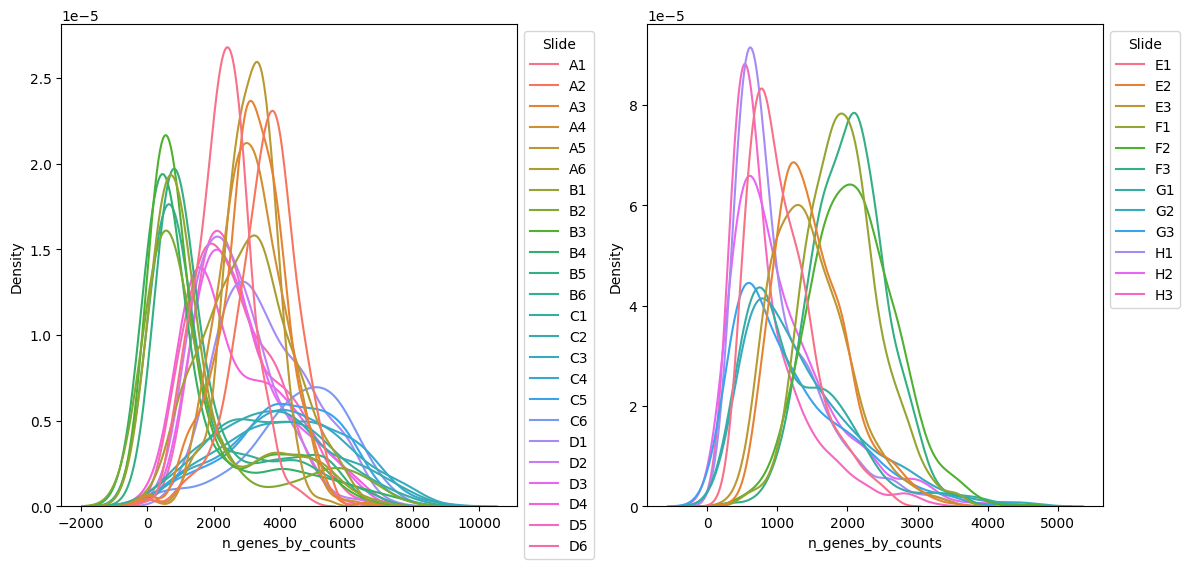

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(df[df["Slide"].isin(list(adatas_dict.keys())[:-12])], x="n_genes_by_counts", hue="Slide", ax=axs[0], label="Slide")
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.legend(loc="upper left", mode = "expand", ncol = 3)

gc.collect()

sns.kdeplot(df[df["Slide"].isin(list(adatas_dict.keys())[-12:])], x="n_genes_by_counts", hue="Slide", ax=axs[1])
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
gc.collect()

plt.show()

In [133]:
df = []
for i in range(len(list(adatas_dict.keys()))):
    x = adatas_dict[list(adatas_dict.keys())[i]].var[["n_cells_by_counts"]]
    x["total_count"] = adatas_dict[list(adatas_dict.keys())[i]].var["total_counts"]
    x["Slide"] = list(adatas_dict.keys())[i]
    df.append(x)
df = pd.concat(df)
df


n_cells_by_counts  total_count Slide
FO538757.1                 80    58.983177    A1
SAMD11                    298   354.496814    A1
NOC2L                     244   251.816716    A1
KLHL17                     64    48.703753    A1
PLEKHN1                    15    10.397208    A1
...                       ...          ...   ...
TMLHE                       1     0.693147    H3
SPRY3                       1     0.693147    H3
VAMP7                       7     5.662960    H3
DDX3Y                       1     0.693147    H3
TMSB4Y                      1     0.693147    H3

[553128 rows x 3 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


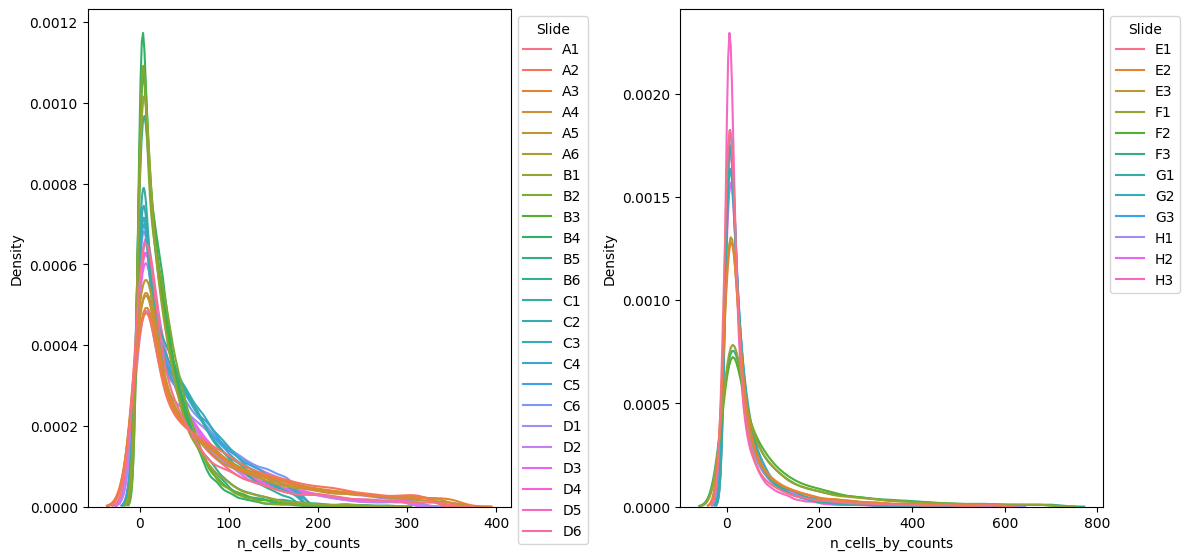

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(df[df["Slide"].isin(list(adatas_dict.keys())[:-12])], x="n_cells_by_counts", hue="Slide", ax=axs[0])
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
plt.legend(loc="upper left", mode = "expand", ncol = 3)
gc.collect()
sns.kdeplot(df[df["Slide"].isin(list(adatas_dict.keys())[-12:])], x="n_cells_by_counts", hue="Slide", ax=axs[1])
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
gc.collect()
plt.show()

In [126]:
# Compare the number of genes and spots
df = {"Sample":[], "No. of spots":[], "No. of genes":[]}
df1 = []
for i in range(len(list(adatas_dict.keys()))):
    df["Sample"] = list(adatas_dict.keys())[i]
    df["No. of spots"] = adatas_dict[list(adatas_dict.keys())[i]].shape[0]
    df["No. of genes"] = adatas_dict[list(adatas_dict.keys())[i]].shape[1]
    df1.append(pd.DataFrame(df, index=[i]))
df1 = pd.concat(df1)
df1

Sample  No. of spots  No. of genes
0      A1           346         15045
1      A2           325         15526
2      A3           359         15517
3      A4           343         15583
4      A5           332         15638
5      A6           360         15645
6      B1           295         15109
7      B2           270         15290
8      B3           298         15215
9      B4           283         15289
10     B5           289         15273
11     B6           277         15387
12     C1           176         15557
13     C2           187         15706
14     C3           180         15821
15     C4           184         15842
16     C5           181         15721
17     C6           178         15772
18     D1           306         15661
19     D2           303         15396
20     D3           301         15529
21     D4           302         15503
22     D5           306         15666
23     D6           315         15409
24     E1           587         15701
25     E2           572         15167
26     E3           570         15097
27     F1           691         14861
28     F2           695         15041
29     F3           712         15067
30     G1           441         14992
31     G2           467         15258
32     G3           463         15035
33     H1           613         15029
34     H2           603         14907
35     H3           510         14873

<Axes: xlabel='Sample', ylabel='No. of spots'>

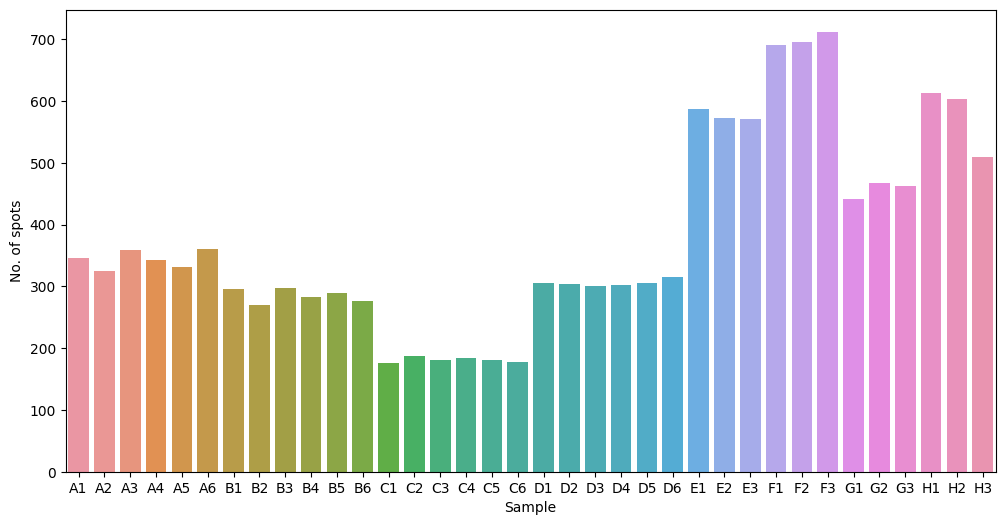

In [128]:
# Plot number of spots
plt.figure(figsize=(12, 6))
sns.barplot(data=df1, x="Sample", y="No. of spots")

In [142]:
img_dir = f'{abs_path}/DeepHis2Exp/Dataset/her2st/data/ST-imgs'
names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'H1', 'H2', 'H3']
def get_img(img_dir, name):
    pre = img_dir+'/'+name[0]+'/'+name
    fig_name = os.listdir(pre)[0]
    path = pre+'/'+fig_name
    im = np.array(Image.open(path))
    return im
get_img(img_dir, names[0]).shape

(7435, 6954, 3)

36it [01:00,  1.68s/it]


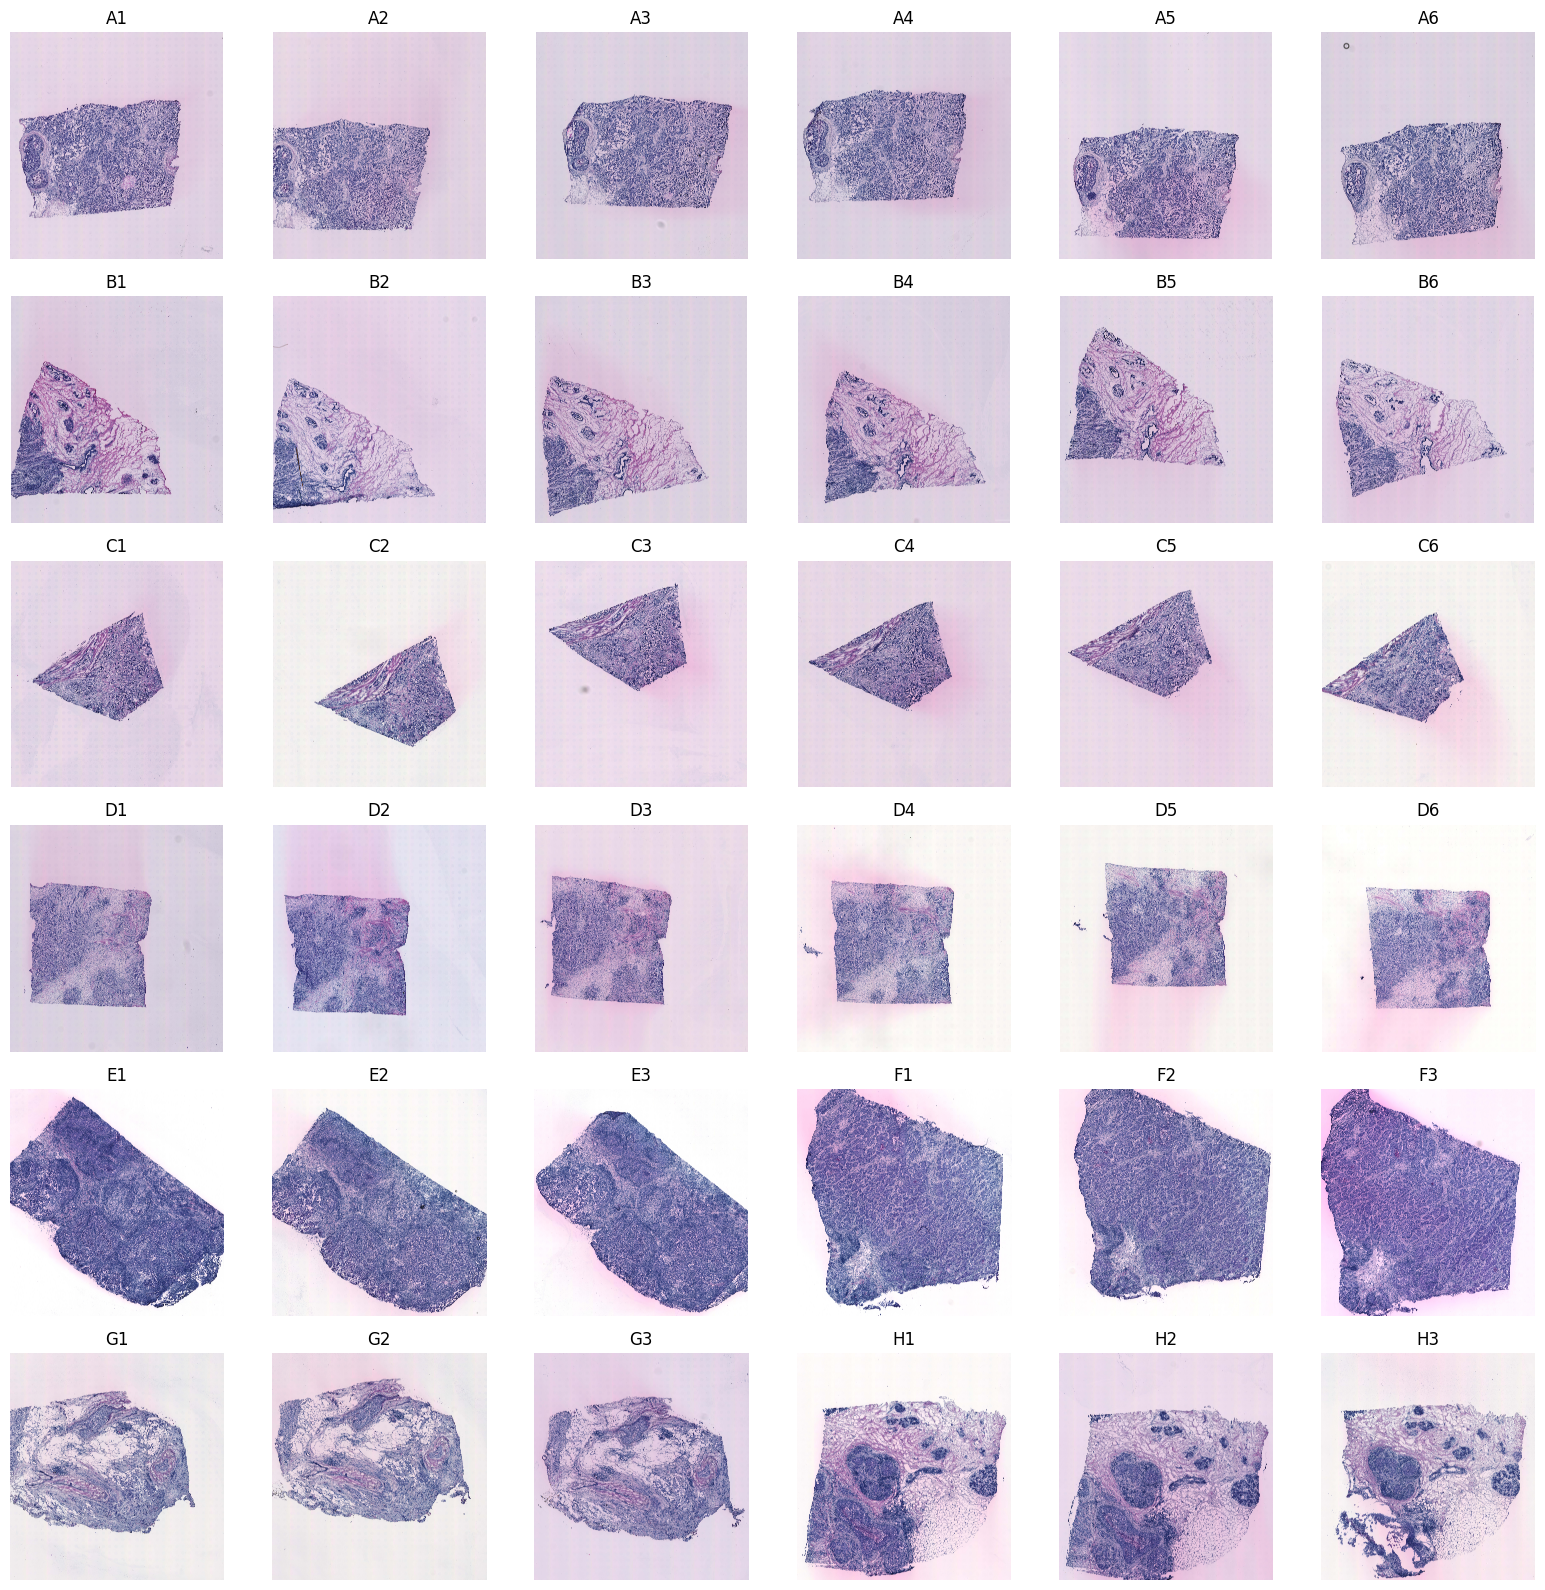

In [147]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
import gc

img_dir = f'{abs_path}/DeepHis2Exp/Dataset/her2st/data/ST-imgs'
names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 
         'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 
         'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'H1', 'H2', 'H3']

def get_img(img_dir, name):
    pre = img_dir+'/'+name[0]+'/'+name
    fig_name = os.listdir(pre)[0]
    path = pre+'/'+fig_name
    im = np.array(Image.open(path))
    return im

# Create a 6 x 6 subplot grid
fig, axes = plt.subplots(6, 6, figsize=(16, 16))

# Iterate through names and plot each image
for i, name in tqdm.tqdm(enumerate(names)):
    gc.collect()
    row, col = divmod(i, 6)
    img = get_img(img_dir, name)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels
    axes[row, col].set_title(name)
plt.tight_layout()
plt.savefig("BC_her2st_overview.pdf", dpi=600)
plt.show()


# Kidney visium dataset

In [1]:
ls /afm01/UQ/Q1851/Quan/Visium/Visium12/hires_image

2021_01_19__RecognizedCode_S1_15K_onelayer.tif  VLP12_A/
2021_01_19__RecognizedCode_S2_15K_onelayer.tif  VLP12_B/
2021_01_19__RecognizedCode_S3_15K_onelayer.tif  VLP12_C/
2021_01_19__RecognizedCode_S4_15K_onelayer.tif  VLP12_D/


# BC_visium dataset

In [4]:
# Breast cancer BC_visium dataset
import scanpy as sc
import glob

dataset_name = "BC_visium"
adata_path = glob.glob("../../Dataset/BC_visium/*h5ad")[:-1]
target_gene_list = np.load("../../Dataset/Gene_list/Gene_list_func_BC_visium.npy").tolist()
adata_dict = {i.split("/")[-1].split(".")[0]: sc.read_h5ad(i)[:,target_gene_list] for i in adata_path}
adata_dict


{'1142243F': View of AnnData object with n_obs × n_vars = 4087 × 1630
     obs: 'in_tissue', 'array_row', 'array_col', 'nCount_RNA', 'nFeature_RNA', 'patientid', 'subtype', 'Classification', 'Grouped annotations', 'n_genes'
     var: 'gene_ids', 'feature_types'
     uns: 'spatial'
     obsm: 'spatial',
 'CID4535': View of AnnData object with n_obs × n_vars = 1028 × 1630
     obs: 'in_tissue', 'array_row', 'array_col', 'nCount_RNA', 'nFeature_RNA', 'subtype', 'patientid', 'Classification', 'Grouped annotations', 'n_genes'
     var: 'gene_ids', 'feature_types'
     uns: 'spatial'
     obsm: 'spatial',
 'CID4290': View of AnnData object with n_obs × n_vars = 2419 × 1630
     obs: 'in_tissue', 'array_row', 'array_col', 'nCount_RNA', 'nFeature_RNA', 'subtype', 'patientid', 'Classification', 'Grouped annotations', 'n_genes'
     var: 'gene_ids', 'feature_types'
     uns: 'spatial'
     obsm: 'spatial',
 '1160920F': View of AnnData object with n_obs × n_vars = 4846 × 1630
     obs: 'in_tissue

In [5]:
# Compute QC metrics
for i in range(len(list(adata_dict.keys()))):
    sc.pp.calculate_qc_metrics(adata_dict[list(adata_dict.keys())[i]], log1p=False, inplace=True)

In [10]:
# Plot QC metrics n_genes_by_counts
df = []
for i in range(len(list(adata_dict.keys()))):
    x = adata_dict[list(adata_dict.keys())[i]].obs[["n_genes_by_counts"]]
    x["Slide"] = list(adata_dict.keys())[i]
    df.append(x)
df = pd.concat(df)
df


n_genes_by_counts     Slide
ATCTATCGATGATCAA-1                309  1142243F
CGGTAACAAGATACAT-1                334  1142243F
TCGCCGGAGAGTCTTA-1                284  1142243F
GGAGGAGTGTGTTTAT-1                343  1142243F
TTAGGTGTGACTGGTC-1                302  1142243F
...                               ...       ...
TGCAGTGGTAGGGAAC-1                335  CID44971
AGCGAGACGTGAAGGC-1                459  CID44971
CAGTGTTAATCTCTCA-1                242  CID44971
GATCGCTGTGGTGCGT-1                336  CID44971
CTCTGCAGGCATTCTT-1                232  CID44971

[22531 rows x 2 columns]

In [11]:
# names = [i.split("/")[-1].split(".")[0] for i in adata_path]
# names.sort()
# df['Slide'] = pd.Categorical(df['Slide'], categories=names, ordered=True)


7570

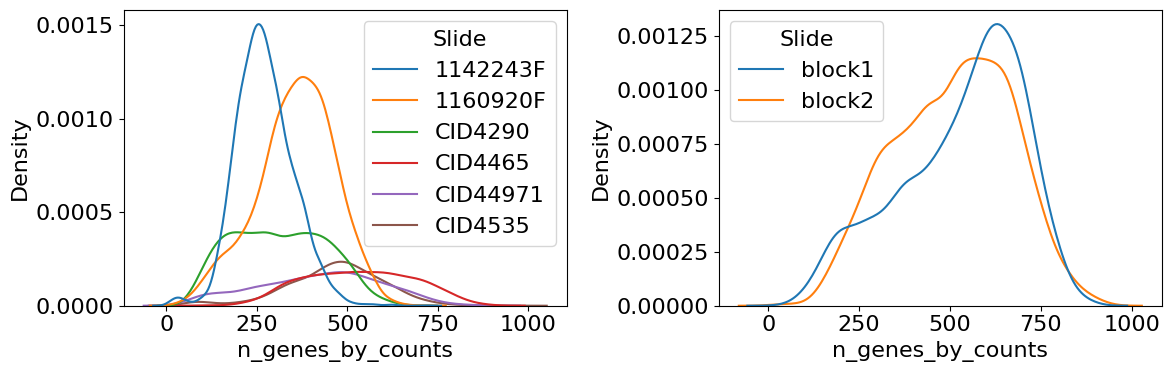

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

df_alex = df[~df["Slide"].isin(["block1", "block2"])]
df_alex = df_alex.sort_values("Slide")
df_10x = df[df["Slide"].isin(["block1", "block2"])]
df_10x = df_10x.sort_values("Slide")

plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the first subplot
sns.kdeplot(df_alex, x="n_genes_by_counts", hue="Slide", ax=axs[0])

# Plotting the second subplot
sns.kdeplot(df_10x, x="n_genes_by_counts", hue="Slide", ax=axs[1])

plt.tight_layout()
plt.savefig("ID_expression_detection.pdf", dpi=300)
gc.collect()
# plt.show()


In [19]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# List of file paths for your 6 images
names = [i.split("/")[-1].split(".")[0] for i in adata_path]
image_paths = [f"../../Dataset/BC_visium/{name}/image.tif" for name in names]

images = []
for image_path in image_paths:
    img = np.array(Image.open(image_path))
    images.append(img)

R, G, B = {}, {}, {}
for i in range(len(names)):
    name = names[i]
    R[name+"_mean"] = images[i][:,:,0].mean()
    G[name+"_mean"] = images[i][:,:,1].mean()
    B[name+"_mean"] = images[i][:,:,2].mean()

df = pd.concat([pd.DataFrame(R, index=["Red"]),
                pd.DataFrame(G, index=["Green"]),
                pd.DataFrame(B, index=["Blue"]),
               ]).T
df["Slide"] = names

# Melt the DataFrame
melted_df = pd.melt(df, id_vars=['Slide'], var_name='Color', value_name='Mean Value')

# Display the melted DataFrame
melted_df


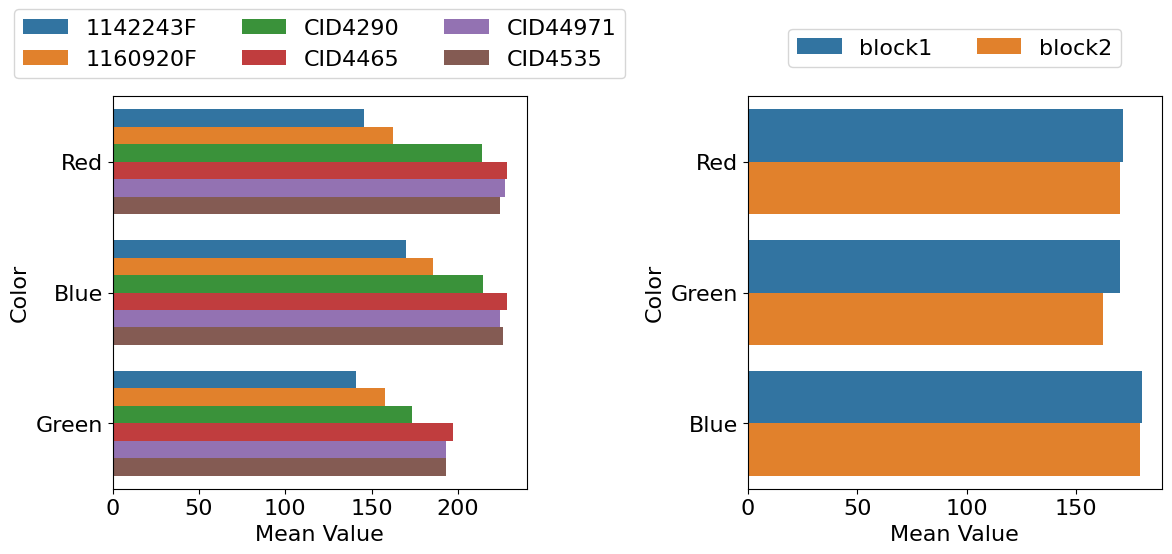

In [26]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the barplot
df_alex_color = melted_df[~melted_df["Slide"].isin(["block1", "block2"])]
df_alex_color = df_alex_color.sort_values("Slide")
sns.barplot(df_alex_color, y="Color", x="Mean Value", orient="h",
            hue="Slide", ax=axs[0])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)


df_10x_color = melted_df[melted_df["Slide"].isin(["block1", "block2"])]
df_10x_color = df_10x_color.sort_values("Slide")
sns.barplot(df_10x_color, y="Color", x="Mean Value", orient="h",
            hue="Slide", ax=axs[1])

# Move the legend to the upper center horizontally
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.tight_layout()

plt.savefig("ID_color_detection.pdf", dpi=300)
plt.show()
